# Author
[Bete (Ranma-2000)](https://github.com/Ranma-2000)

## 1. Loading data files

In [ ]:
%cd qrs-tutorial

In [ ]:
import pandas as pd
heartbeat = pd.read_csv('Khoa_200722_1705.csv', header=None)
heartbeat = heartbeat[0].tolist()

In [ ]:
%cd ../

## 2. Methods

### Sliding Windows

In [9]:
import os
import wfdb as wf
import numpy as np
from scipy import signal
import data.mitdbread as dm
from biosppy.signals import ecg  # R peaks detection algorithm 1
from utils.QRS_util import *  # R peaks detection algorithm 2
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

In [2]:
records = dm.get_records()
print(records)

['data/mitdb\\100', 'data/mitdb\\101', 'data/mitdb\\102', 'data/mitdb\\103', 'data/mitdb\\104', 'data/mitdb\\105', 'data/mitdb\\106', 'data/mitdb\\107', 'data/mitdb\\108', 'data/mitdb\\109', 'data/mitdb\\111', 'data/mitdb\\112', 'data/mitdb\\113', 'data/mitdb\\114', 'data/mitdb\\115', 'data/mitdb\\116', 'data/mitdb\\117', 'data/mitdb\\118', 'data/mitdb\\119', 'data/mitdb\\121', 'data/mitdb\\122', 'data/mitdb\\123', 'data/mitdb\\124', 'data/mitdb\\200', 'data/mitdb\\201', 'data/mitdb\\202', 'data/mitdb\\203', 'data/mitdb\\205', 'data/mitdb\\207', 'data/mitdb\\208', 'data/mitdb\\209', 'data/mitdb\\210', 'data/mitdb\\212', 'data/mitdb\\213', 'data/mitdb\\214', 'data/mitdb\\215', 'data/mitdb\\217', 'data/mitdb\\219', 'data/mitdb\\220', 'data/mitdb\\221', 'data/mitdb\\222', 'data/mitdb\\223', 'data/mitdb\\228', 'data/mitdb\\230', 'data/mitdb\\231', 'data/mitdb\\232', 'data/mitdb\\233', 'data/mitdb\\234']


In [18]:
# plt.ioff()

# Instead of using the annotations to find the beats, we will
# use R-peak detection instead. The reason for this is so that
# the same logic can be used to analyze new and un-annotated
# ECG data. We use the annotations here only to classify the
# beat as either Normal or Abnormal and to train the model.
# Reference:
# https://physionet.org/physiobank/database/html/mitdbdir/intro.htm
realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

# Loop through each input file. Each file contains one
# record of ECG readings, sampled at 360 readings per
# second.
for path in records:
    pathpts = path.split('/')
    fn = pathpts[-1]
    print('Loading file:', path)

    # Read in the data
    record = wf.rdsamp(path)
    annotation = wf.rdann(path, 'atr')

    # Print some meta informations
    print('    Sampling frequency used for this record:', record[1].get('fs'))
    print('    Shape of loaded data array:', record[0].shape)
    print('    Number of loaded annotations:', len(annotation.num))

    # Get the ECG values from the file.
    data = record[0].transpose()
    print(data)

    # Generate the classifications based on the annotations.
    # 0.0 = undetermined
    # 1.0 = normal
    # 2.0 = abnormal
    cat = np.array(annotation.symbol)
    rate = np.zeros_like(cat, dtype='float')
    for catid, catval in enumerate(cat):
        if (catval == 'N'):
            rate[catid] = 1.0 # Normal
        elif (catval in realbeats):
            rate[catid] = 2.0 # Abnormal
    rates = np.zeros_like(data[0], dtype='float')
    rates[annotation.sample] = rate

    indices = np.arange(data[0].size, dtype='int')

    # Process each channel separately (2 per input file).
    for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('    ECG channel type:', chname)
        # for i in range(0, len(channel) - 360, 360):
        #     channel = channel*1000
        #     # Find rpeaks in the ECG data. Most should match with the annotations.
        #     R_peaks, S_pint, Q_point = EKG_QRS_detect(channel[i:i+360], record[1].get('fs'), True, False)
            # plt.figure()
            # plt.plot(channel[i:i+360])
            # if len(R_peaks) > 0 and len(S_pint) > 0 and len(Q_point) > 0:
            #     plt.plot(R_peaks, channel[i:i+360][R_peaks], 'r-o')
            #     plt.plot(S_pint, channel[i:i+360][S_pint], 'y-o')
            #     plt.plot(Q_point, channel[i:i+360][Q_point], 'b-o')
            #     fig_name = path.split("\\")[-1]
            # plt.savefig(f'{fig_name}_{i}.png')

Loading file: data/mitdb\100
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 2274
[[-0.145 -0.145 -0.145 ... -0.675 -0.765 -1.28 ]
 [-0.065 -0.065 -0.065 ... -0.365 -0.335  0.   ]]
    ECG channel type: MLII
    ECG channel type: V5
Loading file: data/mitdb\101
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 1874
[[-0.345 -0.345 -0.345 ... -0.295 -0.29   0.   ]
 [-0.16  -0.16  -0.16  ... -0.11  -0.11   0.   ]]
    ECG channel type: MLII
    ECG channel type: V1
Loading file: data/mitdb\102
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 2192
[[-0.2   -0.2   -0.2   ... -0.17  -0.195  0.   ]
 [ 0.005  0.005  0.005 ...  0.2    0.195  0.   ]]
    ECG channel type: V5
    ECG channel type: V2
Loading file: data/mitdb\103
    Sampling frequency used for this 

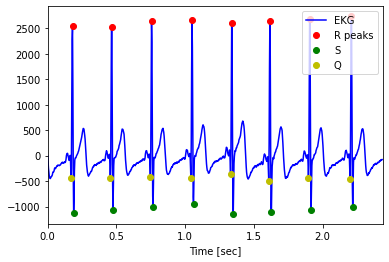

[ 65 168 272 378 482 582 687 795]
[2514 2497 2607 2637 2580 2622 2652 2707]


In [58]:
import os
import sys

import numpy as np

from utils.QRS_util import *
import pandas as pd

'''
QRS detection demo
@author: Kemeng Chen: kemengchen@email.arizona.edu
'''


def QRS_test():
    """
    QRS detection on file_name
    assuming 360 Hz sampling rate, may not work with very low sampling rate signal
    args:
        file_name: file containing ecg data in one column
    """
    fs = 360
    # file_path = os.path.join(os.getcwd(), 'data', file_name)
    # if not os.path.isfile(file_path):
    #     raise AssertionError(file_path, 'not exists')
    # ecg = read_ecg(file_path)
    # print(type(ecg))

    heartbeat = pd.read_csv('QRS-detection/data/Khoa_200722_1705.csv', header=None)
    heartbeat = heartbeat[0].tolist()
    heartbeat = np.asarray(heartbeat)
    R_peaks, S_pint, Q_point = EKG_QRS_detect(heartbeat, fs, True, True)
    print(R_peaks)
    print(heartbeat[R_peaks])


if __name__ == '__main__':
    # if len(sys.argv) < 2:
    #     raise ValueError('No file name specified')
    # QRS_test(sys.argv[1])


    QRS_test()
